Group PGH013: Dhruv Baid, Guolun Li, Shangyu Li, Uday Sharma, Yi Xin Xiang

In [44]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
plt.style.use("seaborn")

**Introduction – Data Description, Cleaning, and Pre-Processing** 

In [3]:
df = pd.read_csv('OFFERING.tsv', sep='\t') # read the file

The data are obtained from the SEC website, as a part of their Form D datasets. It contains information on the Form D submissions filed by companies in their EDGAR document submissions.

The file contains information on new securities offered, with each row corresponding to a unique EDGAR submission. There are 14187 rows, where each row corresponds to a Form D submission by a company, where the company is looking to offer new securities.  The columns include accession number, which is a unique identifier for each submission, and other characteristics of that submission. There are 41 columns including the accession number.


| Number | Variable | Description | Type |
| --- | --- | --- | --- 
| 1 | ACCESSIONNUMBER | This is the unique identifier for each row (company), and it corresponds to an EDGAR submission. It is alphanumeric with 20 characters, and of the format *xxxxxxxxxx-xx-xxxxxx*. | string |
| 2 | INDUSTRYGROUPTYPE | This describes the type of industry the company is from. | category |
| 3 | INVESTMENTFUNDTYPE | This describes the type of security offered by the company. | category |
| 4 | IS40ACT | This is a flag variable to indicate whether the issuer is registered as an investment company under the Investment Company Act of 1940. | category |
| 5 | REVENUERANGE | The dollar range for the revenue of the company, if disclosed. This is only applicable to companies that are not hedge or other pooled investment funds. | category |
| 6 | AGGREGATENETASSETVALUERANGE | The dollar range for the aggregate net asset value for the company, if disclosed. This is only applicable to hedge and other pooled investment funds. | category |
| 7 | FEDERALEXEMPTIONS_ITEMS_LIST | Lists the exemptions given to the company under the Securities Act. | category (multiple possible) |
| 8 | ISAMENDMENT | Whether the listing is an amendment (as opposed to a new notice). | boolean |
| 9 | PREVIOUSACCESSIONNUMBER | The previous accession number the company had, if any. | string |
| 10 | SALE_DATE | The date the security was sold. | datetime |
| 11 | YETTOOCCUR | Whether the sale is yet to occur.  | boolean |
| 12 | MORETHANONEYEAR | Whether the duration of the offering is more than one year. | boolean |
| 13 | ISEQUITYTYPE | Whether the offering is of the type equity. | boolean |
| 14 | ISDEBTTYPE | Whether the offering is of the type debt. | boolean |
| 15 | ISOPTIONTOACQUIRETYPE | Whether the offering is an option, warrant, or other right to acquire another security. | boolean |
| 16 | ISSECURITYTOBEACQUIREDTYPE | Whether the offering is to be acquired upon exercise of option, warrant or other right to acquire security. | boolean |
| 17 | ISPOOLEDINVESTMENTFUNDTYPE | Whether the offering is a pooled investment fund. | boolean |
| 18 | ISTENTANTINCOMMONTYPE | Whether the offering is a tenant-in-common security. | boolean |
| 19 | ISMINERALPROPERTYTYPE | Whether the offering is a mineral property security. | boolean |
| 20 | ISOTHERTYPE | Whether the offering is of some other type. | boolean |
| 21 | DESCRIPTIONOFOTHERTYPE | If the offering is of some other type, then its description. | string |
| 22 | ISBUSINESSCOMBINATIONTRANS | Whether the offering was made in connection with a business combination transaction, like an M&A. | boolean |
| 23 | BUSCOMBCLARIFICATIONOFRESP | The clarification of response provided, if any. | string |
| 24 | MINIMUMINVESTMENTACCEPTED | Minimum investment accepted from an outside investor. | numeric |
| 25 | OVER100RECIPIENTFLAG | Whether there are over 100 recipients for the offering. | boolean |
| 26 | TOTALOFFERINGAMOUNT | Total amount that's being offered. | numeric |
| 27 | TOTALAMOUNTSOLD | Total amount that was sold from the amount offered. | numeric |
| 28 | TOTALREMAINING | Total amount remaining to be sold. | numeric |
| 29 | SALESAMTCLARIFICATIONOFRESP | The clarification of response provided for the sales amount, if any. | string |
| 30 | HASNONACCREDITEDINVESTORS | Whether the securities in the offering have been or may be sold to persons who do not qualify as accredited investors. | boolean |
| 31 | NUMBERNONACCREDITEDINVESTORS | Number of such non-accredited investors, if any. | numeric |
| 32 | TOTALNUMBERALREADYINVESTED | Total number of all investors that have invested in the offering, regardless of their accredited status.| numeric |
| 33 | SALESCOMM_DOLLARAMOUNT | US dollar amount of sales commissions.| numeric |
| 34 | SALESCOMM_ISESTIMATE | Whether the sales commission amount is an estimate.| boolean |
| 35 | FINDERSFEE_DOLLARAMOUNT | The finders fee in USD.| numeric |
| 36 | FINDERSFEE_ISESTIMATE | Whether the finders fee is an estimated value. | boolean |
| 37 | FINDERFEECLARIFICATIONOFRESP | The clarification of response provided for the finders fee, if any. | string |
| 38 | GROSSPROCEEDSUSED_DOLLARAMOUNT | The dollar amount of the gross proceeds of the offering used (or planned to be used) to make payments to promoters, executive officers or directors.| numeric |
| 39 | GROSSPROCEEDSUSED_ISESTIMATE | Whether the dollar amount for the gross proceeds above is an estimate.| boolean |
| 40 | GROSSPROCEEDSUSED_CLAROFRESP | The clarification of response provided for the above gross proceeds, if any.| string |
| 41 | AUTHORIZEDREPRESENTATIVE | Whether the entity signing the form is a duly autorized representative of the issuer.| category |

Out of the 41 columns, 26 of them have one or more missing values. In tackling these missing values, we use the following philosophy: we make a distinction between not knowing something versus knowing that something is not applicable. NaNs should represent "lack of data", or cases where the actual value is unknown. If something is not applicable, then we fill it in with "Not Applicable" instead, since the fact that something is not applicable is additional information in itself, and should be included in the analysis.


If an offering doesn't have any non-accredited investors, either those who have already invested or those who may invest, i.e., HASNONACCREDITEDINVESTORS is False, then the field NUMBERNONACCREDITEDINVESTORS must be 0.

To fix this, for cases when HASNONACCREDITEDINVESTORS is False, we fill in zeros for the NaN values in NUMBERNONACCREDITEDINVESTORS.

In [4]:
df.loc[df.HASNONACCREDITEDINVESTORS == False,'NUMBERNONACCREDITEDINVESTORS']\
=df[df.HASNONACCREDITEDINVESTORS == False].\
    NUMBERNONACCREDITEDINVESTORS.fillna(0)

The following columns do not have any missing data:

- ACCESSIONNUMBER
- INDUSTRYGROUPTYPE
- FEDERALEXEMPTIONS_ITEMS_LIST
- ISAMENDMENT
- MORETHANONEYEAR
- ISBUSINESSCOMBINATIONTRANS
- MINIMUMINVESTMENTACCEPTED
- TOTALOFFERINGAMOUNT
- TOTALAMOUNTSOLD
- TOTALREMAINING
- HASNONACCREDITEDINVESTORS
- TOTALNUMBERALREADYINVESTED
- SALESCOMM_DOLLARAMOUNT
- FINDERSFEE_DOLLARAMOUNT
- GROSSPROCEEDSUSED_DOLLARAMOUNT

1\. IS40ACT

We see that in addition to True and False values, there are also NaN values. We can distinguish between the NaNs and False values after looking at the actual Form D: the True and False values are only applicable to firms that come under the "Other Investment Fund" subsubcategory in "Banking and Financial Services" -> "Pooled Investment Fund". 

Hence, it is a better idea to change this variable from boolean to categorical, and have "Not Applicable" as the third category.

In [5]:
df.IS40ACT = df.IS40ACT.fillna('Not Applicable')

2\. INVESTMENTFUNDTYPE

There are around 5932 rows with missing values. On further inspection, we see that all of these missing values correspond to rows where the Investment Company Act of 1940 is not applicable. This makes sense since these companies are not Investment Funds in the first place, and hence cannot have a type.

To fix this, we replace the NaN values with another category: "Not Applicable".

In [6]:
df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.fillna("Not Applicable")

3 and 4. REVENUERANGE and AGGREGATENETASSETVALUERANGE

We observe that the sum of the number of missing values in the two columns is equal to the total number of rows we have. Looking at Form D, we see that REVENUERANGE is not applicable to firms that are "hedge" or "other investment" funds, and AGGREGATENETASSETVALUERANGE is not applicable to all the other firms.

To fix this, we set the missing values to the category "Not Applicable" instead.

In [7]:
df.REVENUERANGE = df.REVENUERANGE.fillna("Not Applicable")
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE.\
    fillna("Not Applicable")

5\. PREVIOUSACCESSIONNUMBER

The missing values correspond to cases where there isn't a previous accession number. We can set the NaN values to "Not Applicable" instead.

In [8]:
df.PREVIOUSACCESSIONNUMBER = df.PREVIOUSACCESSIONNUMBER.\
    fillna("Not Applicable")

6 and 7. SALE_DATE and YETTOOCCUR

Here, it seems like NaN for YETTOOCCUR represent the value False. So, we replace the NaNs with False. 

We also observe that the missing values are complementary: for cases when YETTOOCCUR is True, there is no associated SALE_DATE, as expected. However, fixing this is tricky: SALE_DATE is of type datetime. So, we leave the NaN values as-is.

In [9]:
df.YETTOOCCUR = df.YETTOOCCUR.fillna(False)

8 to 16. ISEQUITYTYPE, ISDEBTTYPE, ISOPTIONTOACQUIRETYPE, ISSECURITYTOBEACQUIREDTYPE, ISPOOLEDINVESTMENTFUNDTYPE, ISTENANTINCOMMONTYPE, ISMINERALPROPERTYTYPE, ISOTHERTYPE, and DESCRIPTIONOFOTHERTYPE

For the first 8 variables, we see that the missing values correspond to a value of False instead, i.e., when the security is not the relevant type. We can fix this by filling in False.

In [10]:
df.ISEQUITYTYPE = df.ISEQUITYTYPE.fillna(False)
df.ISDEBTTYPE = df.ISDEBTTYPE.fillna(False)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.fillna(False)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.fillna(False)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.fillna(False)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.fillna(False)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.fillna(False)
df.ISOTHERTYPE = df.ISOTHERTYPE.fillna(False)

We also see that the description for "other" type is only NaN when the security is not of "other" type. So, we can fill in "Not Applicable" for the missing values.

In [11]:
df.DESCRIPTIONOFOTHERTYPE = df.DESCRIPTIONOFOTHERTYPE.\
    fillna('Not Applicable')

17 to 20. BUSCOMBCLARIFICATIONOFRESP, SALESAMTCLARIFICATIONOFRESP, FINDERFEECLARIFICATIONOFRESP, and GROSSPROCEEDSUSED_CLAROFRESP

All of these variables are NaN when there is no provided clarification response. As the clarification is optional, we can set the NaN values to "Not Applicable".

In [12]:
df.BUSCOMBCLARIFICATIONOFRESP = df.BUSCOMBCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.SALESAMTCLARIFICATIONOFRESP = df.SALESAMTCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.FINDERFEECLARIFICATIONOFRESP = df.FINDERFEECLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.GROSSPROCEEDSUSED_CLAROFRESP = df.GROSSPROCEEDSUSED_CLAROFRESP.\
    fillna("Not Applicable")

21\. OVER100RECIPIENTFLAG

We see that all the rows have missing values for this variable. The cause here is ambigious: one possibility is that the variable is False for all the rows. Another possibility that the data from the form were not compiled – on the form, there is an option to identify additional recipients by attaching more pages, and it is possible that these pages were not counted while making the dataset.

As having all rows as "False" doesn't add any value to any analysis, to be conservative, we drop this column to avoid falsely labelling rows that are potentially "True" as "False".

In [13]:
df = df.drop(columns=['OVER100RECIPIENTFLAG'])

22\. NUMBERNONACCREDITEDINVESTORS

As discussed earlier in the consistency check, we see that the NaN values remaining refer to values that are not known, as the number of investors could be either 0 or more. So, the NaNs represent "missingness" and should be left as such.

23 to 25. SALESCOMM_ISESTIMATE, FINDERSFEE_ISESTIMATE, and GROSSPROCEEDSUSED_ISESTIMATE

Here, the missing values refer to cases where the value is False, meaning that the respective dollar values are exact and not an estimate. From the actual form, we observe that these variables are represented by checkboxes that are optional to fill, i.e., they are marked when True but left empty when False. We fix them by filling in False instead.

In [14]:
df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.fillna(False)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.fillna(False)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE.\
    fillna(False)

26\. AUTHORIZEDREPRESENTATIVE

We note that there are missing values in addition to True and False. However, SEC guidelines say that all Forms D must be signed by an authorized representative. This makes the meaning of False and NaN values ambiguous, as the signature of an authorized representative is mandatory in the first place. So, we leave the NaN values as-is.

None of these columns seem to indicate why the value for AUTHORIZEDREPRESENTATIVE could be missing. So, we leave the NaN values as-is.

Next, we translate the variables to the appropriate format.

First, we convert all the numeric values to the appropriate format. The columns *TOTALOFFERINGAMOUNT* and *TOTALREMAINING* contain some values marked 'Indefinite', which we replace with infinity. According to which data type is appropriate, some columns are converted to integers, and others to floats (when decimal points make sense, or if we have missing values).

In [15]:
df.MINIMUMINVESTMENTACCEPTED = df.MINIMUMINVESTMENTACCEPTED.\
    astype('float64')
df.TOTALOFFERINGAMOUNT = df.TOTALOFFERINGAMOUNT.\
    replace('Indefinite',np.inf).astype('float64')
df.TOTALAMOUNTSOLD = df.TOTALAMOUNTSOLD.astype('float64')
df.TOTALREMAINING = df.TOTALREMAINING.replace('Indefinite',\
    np.inf).astype('float64')
df.NUMBERNONACCREDITEDINVESTORS = \
    df.NUMBERNONACCREDITEDINVESTORS.astype('float64')
df.TOTALNUMBERALREADYINVESTED = df.TOTALNUMBERALREADYINVESTED\
    .astype('int64')
df.SALESCOMM_DOLLARAMOUNT = df.SALESCOMM_DOLLARAMOUNT\
    .astype('float64')
df.FINDERSFEE_DOLLARAMOUNT = df.FINDERSFEE_DOLLARAMOUNT\
    .astype('float64')
df.GROSSPROCEEDSUSED_DOLLARAMOUNT = \
    df.GROSSPROCEEDSUSED_DOLLARAMOUNT.astype('float64')

Next, we convert the variables that are categorical, and lack a natural ordering. For the special case of categorical variables where we only have True or False values (and no missing values), we can convert them to the type boolean.

In [16]:
df.ISAMENDMENT = df.ISAMENDMENT.astype(bool)
df.YETTOOCCUR = df.YETTOOCCUR.astype(bool)
df.MORETHANONEYEAR = df.MORETHANONEYEAR.astype(bool)
df.ISEQUITYTYPE = df.ISEQUITYTYPE.astype(bool)
df.ISDEBTTYPE = df.ISDEBTTYPE.astype(bool)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.astype(bool)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.astype(bool)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.astype(bool)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.astype(bool)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.astype(bool)
df.ISOTHERTYPE = df.ISOTHERTYPE.astype(bool)
df.ISBUSINESSCOMBINATIONTRANS = df.ISBUSINESSCOMBINATIONTRANS.astype(bool)
df.HASNONACCREDITEDINVESTORS = df.HASNONACCREDITEDINVESTORS.astype(bool)
df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.astype(bool)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.astype(bool)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE\
    .astype(bool)

df.INDUSTRYGROUPTYPE = df.INDUSTRYGROUPTYPE.astype('category')
df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.astype('category')
df.IS40ACT = df.IS40ACT.astype('category')
df.REVENUERANGE = df.REVENUERANGE.astype('category')
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE\
    .astype('category')
df.AUTHORIZEDREPRESENTATIVE = df.AUTHORIZEDREPRESENTATIVE.astype('category')

Finally, we set SALE_DATE to type datetime.

In [17]:
df.SALE_DATE = df.SALE_DATE.astype('datetime64')

# Analysis 1

**Question**: Are there variables in the data set that could help predict the percentage of offering sold?

**Methods Used**: Natural Language Processing, K-Means Clustering

## Methodology

First, we set up the response variable **y**, equal to the percentage of offering sold.

$$y = \frac{\mathrm{TOTALAMOUNTSOLD}}{\mathrm{TOTALOFFERINGAMOUNT}}$$

In [18]:
idx = (df.TOTALOFFERINGAMOUNT!=np.inf)
y = (df.TOTALAMOUNTSOLD[idx] / df.TOTALOFFERINGAMOUNT[idx])

Note that we discard the rows where the total offering amount is undetermined. We are left with 8,541 rows from the original 14,187.

In [19]:
len(y)

8541

For performing Natural Language Processing, we look at the following columns with text data:
- DESCRIPTIONOFOTHERTYPE
- BUSCOMBCLARIFICATIONOFRESP
- SALESAMTCLARIFICATIONOFRESP
- FINDERFEECLARIFICATIONOFRESP
- GROSSPROCEEDSUSED_CLAROFRESP

For the purposes of this analysis, the text "Not Applicable" is replaced with an empty string.

First, we tokenize each column using the following methodology:

1. Tokenize each cell by words, i.e., break it into a sequence of words.

2. Using regular expression, only keep words with alphanumeric characters or the "\$" sign. This will allow us to keep dollar amounts that are included in some of the descriptions, while removing punctuations.

3. Convert each word to lowercase *only if* it is not an acronym, defined here as a word that is completely uppercase. This allows us to treat acronyms like "SAFE" separately from the noun "safe". This will allow us to keep things like the "A" in "Series A", as it would otherwise get converted to "a" which is a stop word.

4. Remove English stop words using the built-in dictionary in *nltk*.

5. Parse each word and tag it with the appropriate part of speech using the standard Penn Treebank tagset.

6. Using these tags, lemmatize each word using *nltk*'s implementation of WordNet. For words without any tag, e.g. the dollar sign \$, we keep the word as-is.

7. Finally, perform negation handling by marking each word following a negation word with the "_NEG" tag.

In [20]:
text_cols = ['DESCRIPTIONOFOTHERTYPE','BUSCOMBCLARIFICATIONOFRESP','SALESAMTCLARIFICATIONOFRESP','FINDERFEECLARIFICATIONOFRESP','GROSSPROCEEDSUSED_CLAROFRESP']

# replace "Not Applicable" with an empty string
# extract the text cols for rows for which offering amount is not indefinite
X_input = df[text_cols][idx].replace("Not Applicable",'')

# initialize lemmatizer and stop words
lem = WordNetLemmatizer().lemmatize
stop_words = set(stopwords.words('english'))

# to print random values for demonstration purposes
print_bool = True
print_idx = np.random.choice(list(range(len(X_input)*len(text_cols))),50)
if not print_bool:
    print_idx = []
curr_idx = 0

# function to tokenize each cell
def tokenize(string):

    # for printing examples
    global curr_idx
    curr_idx+=1

    # for an empty string, just return an empty list
    if string=='':
        return []

    # step 1: tokenize by words
    wt = word_tokenize(string)
    
    # step 2: keep words with alphanumeric characters or $
    wt = [word for word in wt if re.match("[a-zA-Z\$0-9].*",word) is not None]

    # step 3: convert to lowercase only if not an acronym
    wt = list(map(lambda x: x if x.isupper() else x.lower(),wt))
    
    # step 4: remove stop words
    wt = [w for w in wt if not w in stop_words]

    # step 5: tag with the appropriate part of speech
    wt = nltk.pos_tag_sents([wt])[0]

    # step 6: lemmatize each word
    holdsent = list(wt)
    for i, wordtuple in enumerate(holdsent):
        wordtmp = list(wordtuple)
        if(wordtmp[1].startswith('N')):
            wordtmp[1] = lem(wordtmp[0], 'n')
        elif(wordtmp[1].startswith('V')):
            wordtmp[1] = lem(wordtmp[0], 'v')
        elif(wordtmp[1].startswith('J')):
            wordtmp[1] = lem(wordtmp[0], 'a')
        elif(wordtmp[1].startswith('R')):
            wordtmp[1] = lem(wordtmp[0], 'r')
        else:
            wordtmp[1] = None
        holdsent[i] = wordtmp
    wt = list(map(lambda x: x[1] if x[1] is not None else x[0], holdsent))

    # step 7: negation handling
    wt = mark_negation(wt)
    
    # for printing examples
    if curr_idx in print_idx:
        print("Original:",string)
        print("After tokenization:",wt)
        print()
        
    return wt

Now, we apply the tokenize function to each column.

To illustrate the tokenization process, we randomly sample a few examples and print the original string, as well as the tokenized version.

In [21]:
for col in text_cols:
    X_input[col] = X_input[col].apply(tokenize)

Original: Common Stock; Warrants to Purchase Common Stock; Common Stock issued upon exercise of Warrants
After tokenization: ['common', 'stock', 'warrant', 'purchase', 'common', 'stock', 'common', 'stock', 'issue', 'upon', 'exercise', 'warrant']

Original: Unit offering, each unit consisting of 1 common share and 1 warrant; each whole warrant exercisable for 1 common share at C$0.12 for 24 months
After tokenization: ['unit', 'offer', 'unit', 'consist', '1', 'common', 'share', '1', 'warrant', 'whole', 'warrant', 'exercisable', '1', 'common', 'share', 'C', '$', '0.12', '24', 'month']

Original: US dollars have been converted from Canadian dollars using the 0.7665 Bank of Canada exchange rate in effect on 7-6-22. Total Remaining to be Sold is the aggregate exercise price of all warrants sold in the offering in the United States.
After tokenization: ['US', 'dollar', 'convert', 'canadian', 'dollar', 'use', '0.7665', 'bank', 'canada', 'exchange', 'rate', 'effect', '7-6-22', 'total', 'remain'

We note that the resulting matrix is quite sparse – the empty list seems to be a big proportion of all five columns. To tackle this, we concatenate the columns into a single column called "*combined_text*", with the following justifications:
- Upon observing the data on Excel, we find that for a majority of the cases, there is not much of an overlap between columns being non-empty, i.e., there are very few rows where we have two or more columns being non-empty.
- Also, our analysis afterwards consists of a "bag-of-words" model for the text. With that in mind, simply concatenating the columns together doesn't adversely affect the analysis as we will still be evaluating how "similar" two rows are based on the words that show up in the different descriptions provided.

In [22]:
#X_input.to_excel("test.xlsx")
X_input.describe()

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
count,8541,8541,8541,8541,8541
unique,358,76,645,286,843
top,[],[],[],[],[]
freq,7839,8456,7695,8047,5677


In [23]:
X_input['combined_text'] = X_input.apply(lambda x: x[0]+x[1]+x[2]+x[3]+x[4],axis=1)
X_input.combined_text = list(map(lambda x: x if x else np.nan, X_input.combined_text))

After combining the data, we drop the rows that have an empty list. We are left with 3938 rows, which is still a good enough amount of data for further analysis.

In [24]:
idx_pick = X_input.combined_text.dropna().index
X, y = X_input.combined_text[idx_pick], y[idx_pick]

In [25]:
len(X)

3938

Next, we want to make use of the tokenized data to get insights about our original data. To do so, we use the term frequency-inverse document frequecy (TF-IDF) metric, which creates a matrix of "adjusted" counts, where the number of rows is equal to 3938 (as found above), and the number of columns is equal to the number of unique terms across the documents.

Here, the adjustment to the counts is done to account for the term's frequency across the documents.

A note on implementation: as the *TfidfVectorizer* function automatically performs preprocessing and tokenizing, we pass a "dummy" preprocessor and tokenizer each as we have already done both the procedures in the previous steps.

Also, we set the ngram_range to (1,1). The justification for this is that since we're looking at financial data, it is unlikely that looking at a longer combination of words will give any more information than looking at a single word. For example, the words "common" and "stock" are usually used together. It is very unlikely that, for example, the word "common" is used in a different context – and that we get more value by looking at "common stock" as a unit.

In [26]:
def dummy_tokenizer(sent):
    return sent

def dummy_preprocessor(sent):
    return sent

vectorizer = TfidfVectorizer(tokenizer = dummy_tokenizer, preprocessor=dummy_preprocessor,ngram_range=(1,1))
vect_fit = vectorizer.fit_transform(list(X))

Before further analysis, we first divide the response, the percentage of offering sold, into bins. Looking at the histogram:

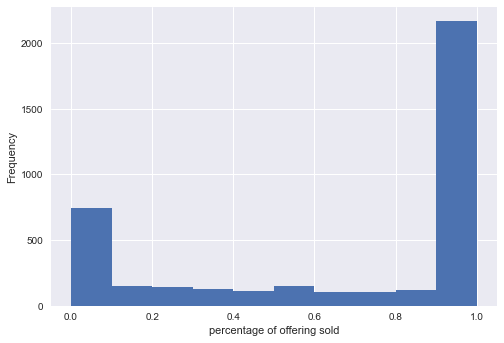

In [27]:
y.plot.hist(bins=10)
plt.xlabel("percentage of offering sold")
plt.show()

Based on this, we make 5 bins for the following range of values:
1. [0, 0.2]
2. (0.2, 0.4]
3. (0.4, 0.6]
4. (0.6, 0.8]
5. (0.8, 1]

In [28]:
def bin_proportion(val, num_bins = 5):
    size = 1/num_bins
    i = size
    while val >= i:
        i += size
    return int(i//size)
        
y_binned = y.apply(bin_proportion)

Now, the final step of the analysis is to use K-means clustering to group the data into different clusters using the TF-IDF matrix. 

We use K-means clustering as the "inertia", a function of the squared euclidean norm, is a fairly good measure of similarity between different rows in the matrix since all the data are at the same scale. Hence, it would be valid to treat the distances between different columns the same way.

We set the number of clusters to 8, a number slightly higher than 5, as we want to be able to "sieve out" the different bins for y into different clusters. In other words, we want to try to get clusters (constructed for the TF-IDF matrix) where a majority of the members belong to y-bins we're interested in. This is ideal as we already know that the cluster contains members which are similar in terms of the text the features contain, so we can then try to find common characteristics between the members of that cluster. This will allow us to identify certain texts which can help predict the percentage of offering that ends up getting sold.

In [85]:
from sklearn.cluster import KMeans
kminit = KMeans(n_clusters=8, n_init=100)
kmout = kminit.fit(vect_fit.todense())

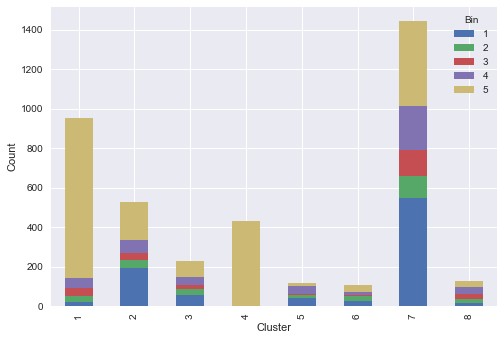

In [86]:
plot_df = pd.DataFrame(df.ACCESSIONNUMBER[X.index])
plot_df['kmclust'] = kmout.labels_ + 1
plot_df['kmclust'] = plot_df['kmclust'].astype('category').cat.as_unordered()
plot_df['actual_bin'] = y_binned.copy()

plot_df = plot_df.groupby(['kmclust','actual_bin'])['ACCESSIONNUMBER'].count().unstack('actual_bin').fillna(0)
plot_df.plot(kind='bar', stacked=True,legend=False)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Bin", bbox_to_anchor=(1.0, 1.0))
plt.show()

## Analysis and Results

### Clusters 1 and 4: high percentage of offerings sold

First, we note that clusters 1 and 4 have a majority of its members belonging to bin 5, i.e., have a percentage of offering sold between 0.8 to 1. We look at the text features of this data on Excel. 

To understand the data better, we first visually inspect the features for the cluster, and then print the unique values from the important column(s).

We also plot a word cloud to visualize the text data.

Cluster 1:

In [189]:
idx = y_binned[kmout.labels_ == 0].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
2,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...
12,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...
25,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...
58,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...
62,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time fixed cost t...


In [190]:
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

GROSSPROCEEDSUSED_CLAROFRESP:
This amount represents a one-time fixed cost to cover fund organizational and operating expenses, including all regulatory filing fees, for the life of the fund.
This amount represents a one-time fixed cost to cover fund organizational and operating expenses, including regulatory filing fees and audit expenses, for the expected life of the fund.
This amount represents a one-time fixed cost to cover fund organizational and operating expenses, including all regulatory filing fees, for the life of the fund


GROSSPROCEEDSUSED_CLAROFRESP


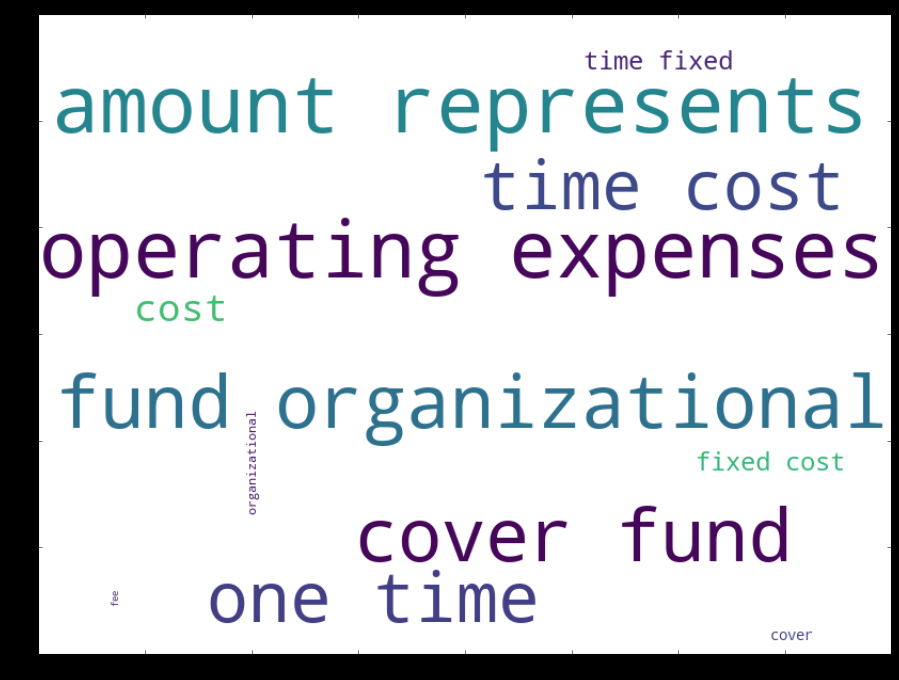

In [205]:
plt.style.use('classic')
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=2).generate(' '.join(df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
print("GROSSPROCEEDSUSED_CLAROFRESP")
plt.imshow(wordcloud)

Cluster 4:

In [192]:
idx = y_binned[kmout.labels_ == 3].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
29,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...
32,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...
34,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...
329,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...
331,Not Applicable,Not Applicable,Not Applicable,Not Applicable,This amount represents a one-time cost to cove...


In [193]:
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

GROSSPROCEEDSUSED_CLAROFRESP:
This amount represents a one-time cost to cover fund organizational and operating expenses.
This amount represents a one time fixed cost to cover fund organizational and operating expenses.
This amount represents a cost to cover fund organizational and operating expenses.
This amount represents a one-time fixed cost to cover fund organizational and operating expenses.
This amount represents a one-time cost to cover the fund organizational and operating expenses.
This amount represents a one-time cost to cover the organizational and operating expenses.
This amount represents a one-time cost fee to cover the organizational and operating expenses.


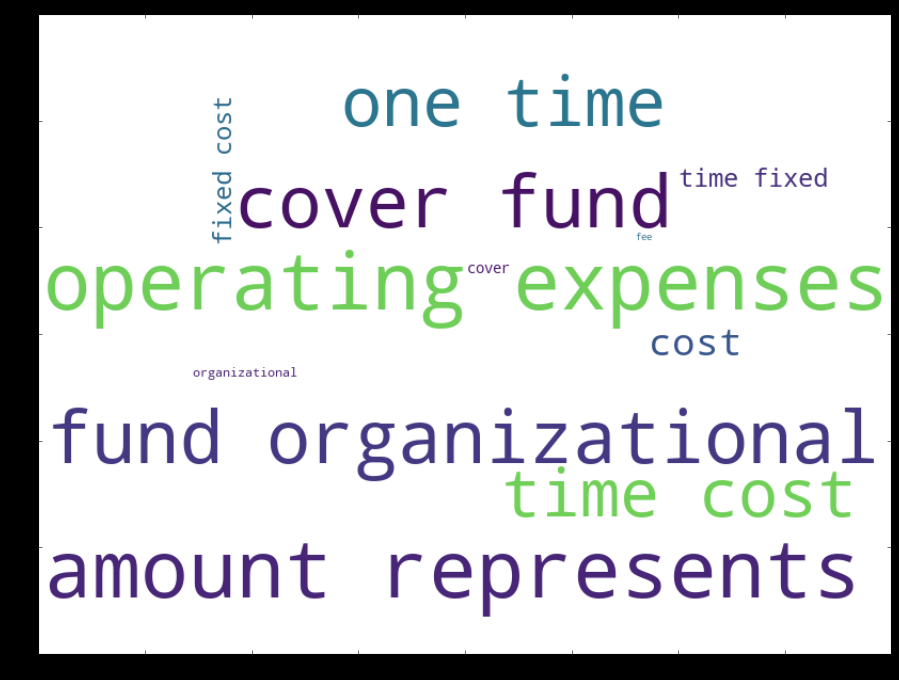

In [196]:
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=2).generate(' '.join(df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

Upon inspecting the files, we notice a common feature to almost all the entries with 80-100% securities sold: the words  the words "one-time cost" and "operating expenses" showing up in the clarification provided to the gross proceeds used.

This can be a predictor for the percentage of securities sold – if a company makes a one-time payment to its promoters using the proceeds of its sales, or has plans to, and if it can be determined that it's for the organizational and operating expenses, then it's likely that the company will sell all of its offerings.

As a proxy for the numerical estimate for the likelihood that a listing with this characteristic has a good sales proportion (between 0.8 to 1), we look at the proportion of members of clusters 1 and 4 that belong to bin 5.

To justify this assumption, we use the following reasoning – the members belonging to a cluster are similar, and we can assume that the clustering is exhaustive, i.e., all the data that has this particular characteristic belongs to the cluster. In this case, we combine clusters 1 and 4 since we've found them to exhibit similar characteristics.

In [167]:
round(np.where(y_binned[(kmout.labels_ == 0) | (kmout.labels_ == 3)]==5,1,0).mean(),4)

0.8963

The interpretation is that if a company makes a one-time payment to its promoters using the proceeds of its sales, and if it can be determined that it's for the organizational and operating expenses, there's a likelihood of 89.63% that it sells 80-100% of its offerings.

### Cluster 5: low percentage of offerings sold

Next, we look at cluster 5, which contains a majority of its members in bins other than 5, i.e., it's likely that the firm does not sell all of its securities. Further, we see that around half of the members are in bins 1 and 2, meaning that the firm sells less than 40% of its securities.

We follow a similar approach as before: visually inspect the data to recognize important columns, print the unique values from those columns, and then plot a word cloud.

In [207]:
idx = y_binned[kmout.labels_ == 4].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
434,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Not Applicable,Not Applicable
607,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re..."
631,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re..."
639,Not Applicable,Not Applicable,"Regarding Item 11, the Issuer may accept small...",Sales Commissions include estimates of the max...,"Item 16 is an estimate of acquisition fees, re..."
966,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Acquisition Fee


In [208]:
print("SALESAMTCLARIFICATIONOFRESP:")
examples = df[text_cols].iloc[idx].SALESAMTCLARIFICATIONOFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

print()
print("FINDERFEECLARIFICATIONOFRESP:")
examples = df[text_cols].iloc[idx].FINDERFEECLARIFICATIONOFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

print()
print("GROSSPROCEEDSUSED_CLAROFRESP:")
examples = df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

SALESAMTCLARIFICATIONOFRESP:
Regarding Item 11, the Issuer may accept smaller investments in the Sponsor's sole discretion.
Regarding Item 11, the Issuer may accept smaller investments in the Issuer's sole discretion.
Regarding Item 11, The Issuer may accept smaller investments at the Sponsor's sole discretion.

FINDERFEECLARIFICATIONOFRESP:
Sales Commissions include estimates of the maximum amount of Selling Commissions, Dealer Fees and Placement Agent Fees that may be paid.
Sales Commissions include estimates of the maximum amount of Selling Commissions and Dealer Fees that may be paid.
Placement fees may be waived in whole or in part by the Issuer in its discretion.
Sales Commissions include estimates of the maximum amount of Selling Commissions, Dealer Fees and Expense Reimbursements that may be paid.
Sales commissions includes estimates of the maximum amount of selling commissions and dealer manager fees that may be paid.
Placement Fee Commissions.
Sales Commissions include estima

SALESAMTCLARIFICATIONOFRESP


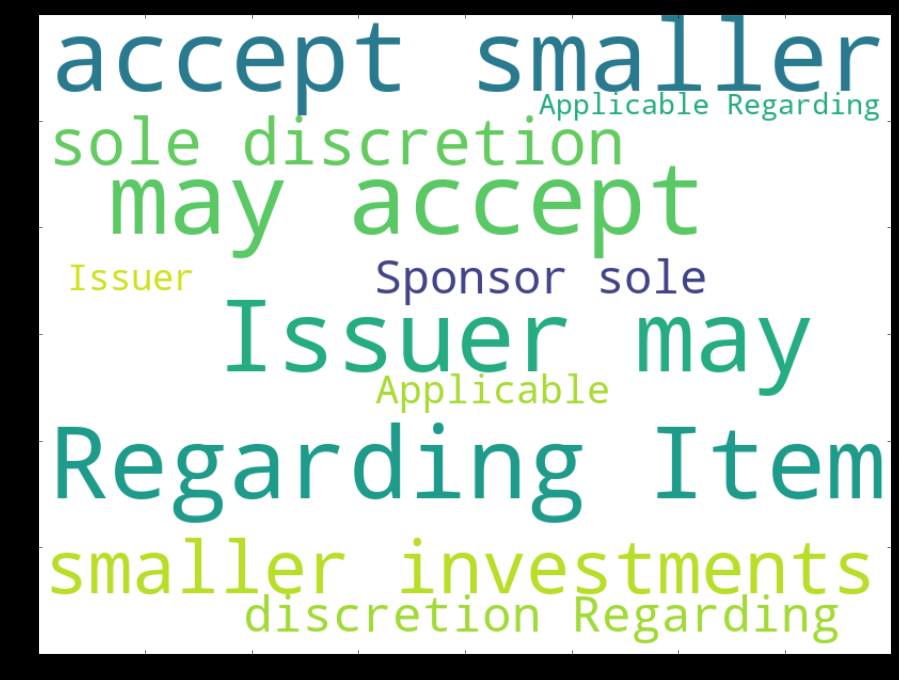

In [209]:
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=3).generate(' '.join(df[text_cols].iloc[idx].SALESAMTCLARIFICATIONOFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
print('SALESAMTCLARIFICATIONOFRESP')
plt.imshow(wordcloud)

FINDERFEECLARIFICATIONOFRESP


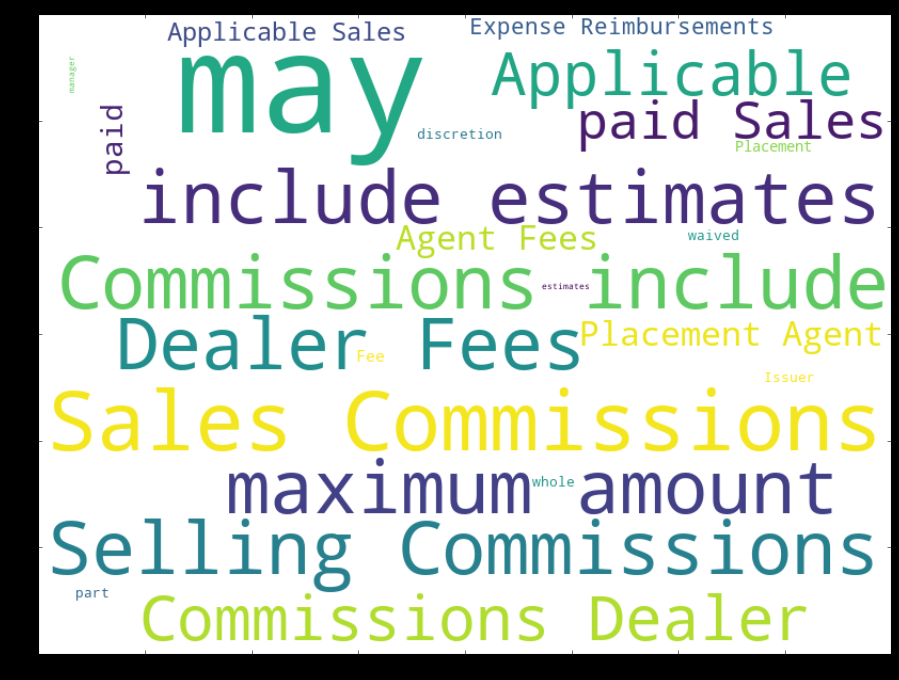

In [210]:
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=2).generate(' '.join(df[text_cols].iloc[idx].FINDERFEECLARIFICATIONOFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
print('FINDERFEECLARIFICATIONOFRESP')
plt.imshow(wordcloud)

GROSSPROCEEDSUSED_CLAROFRESP


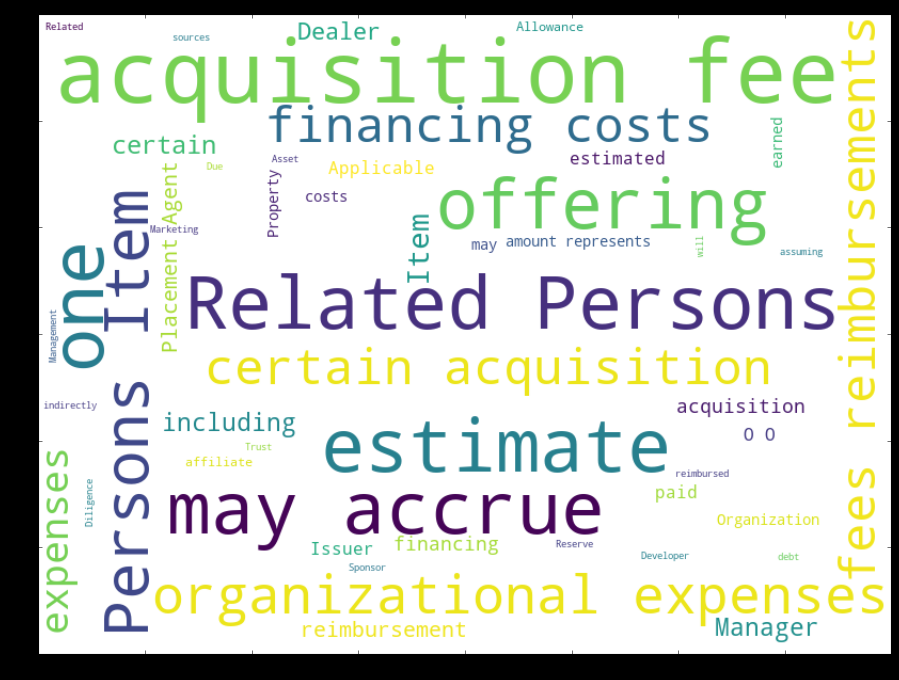

In [211]:
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=2).generate(' '.join(df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
print('GROSSPROCEEDSUSED_CLAROFRESP')
plt.imshow(wordcloud)

Upon inspecting the texts, here are the features common to a majority of the securities that don't sell completely:
- The issuer sometimes accepts investments smaller than the minimum investment specified.
- The finder's fee provided is an estimate rather than the actual value.
- The offering and organizational expenses provided are estimates.

All of these could potentially bring into question the legitimacy and value of the securitiy being offered, and hence deter investors from buying them.

We also make an estimate for the likelihood that a company showing these features is likely to sell very little of its offerings, between 0-40%.

In [174]:
round(np.where((y_binned[kmout.labels_ == 4]==1) | (y_binned[kmout.labels_ == 4]==2),1,0).mean(),4)

0.4958

Meaning, there is a 49.58% likelihood that the company sells very little of its offerings.

### Cluster 8: medium percentage of offerings sold

Finally, we look at cluster 8, which contains a large proportion of its members in bins 2, 3, and 4, meaning that they sold between 20-80% of their offerings.

Again, we follow the same approach.

In [212]:
idx = y_binned[kmout.labels_ == 7].index
#df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')
df[text_cols].iloc[idx].head(5)

,DESCRIPTIONOFOTHERTYPE,BUSCOMBCLARIFICATIONOFRESP,SALESAMTCLARIFICATIONOFRESP,FINDERFEECLARIFICATIONOFRESP,GROSSPROCEEDSUSED_CLAROFRESP
23,Convertible Promissory Notes,Not Applicable,Not Applicable,Not Applicable,Not Applicable
108,Not Applicable,Not Applicable,Includes conversion of previously outstanding ...,Not Applicable,Not Applicable
311,Unsecured convertible notes,Not Applicable,Not Applicable,Not Applicable,Not Applicable
408,Not Applicable,Not Applicable,Includes conversion of previously outstanding ...,Not Applicable,Not Applicable
450,Convertible Promissory Notes,Not Applicable,Not Applicable,Not Applicable,No payments other than ordinary course employm...


In [213]:
print("DESCRIPTIONOFOTHERTYPE:")
examples = df[text_cols].iloc[idx].DESCRIPTIONOFOTHERTYPE.unique()
examples = [item for item in examples if item != "Not Applicable"]
for item in examples:
    print(item)

DESCRIPTIONOFOTHERTYPE:
Convertible Promissory Notes
Unsecured convertible notes
SAFE Notes
Convertible Note
Certain Convertible Promissory Notes that were converted into SAFEs (Simple Agreement for Future Equity), and additional SAFEs
Convertible Notes
Promissory notes convertible into equity securities of the Issuer.
Convertible Promissory Notes with Warrants (Sept. 8, 2022)
notes with warrants
convertible promissory notes
Convertible promissory notes convertible into equity securities of the Issuer and the equity securities to be acquired upon such conversion.
Safe Note Convertible Equity
conversion of notes
convertible promissory note
Offering of convertible promissory notes  and the underlying equity securities issuable upon such conversion.
Convertible promissory notes
Convertible Securities
Convertible note
Convertible debt
Convertible Debt
Convertible Promissory B Note
Convertible promissory notes, convertible into equity
Convertible promissory notes and Common Stock issuable u

GROSSPROCEEDSUSED_CLAROFRESP


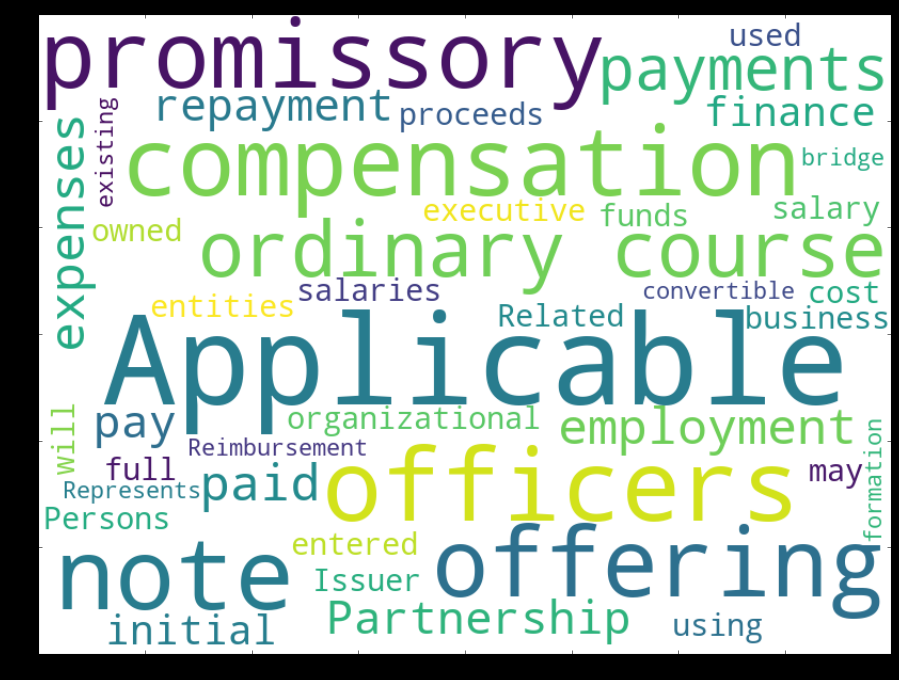

In [222]:
wordcloud = WordCloud(background_color="white",width=800, height=600,collocations=2,relative_scaling=0.2).generate(' '.join(df[text_cols].iloc[idx].GROSSPROCEEDSUSED_CLAROFRESP.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
print('GROSSPROCEEDSUSED_CLAROFRESP')
plt.imshow(wordcloud)
plt.style.use('seaborn')

The conclusion here is apparent – this cluster majorly contains securities of the "Other" type, specifically convertible promissory notes and SAFEs (simple agreement for future equity). These are both popularly used by start-ups to raise money from investors, and pay them back later.

What we can conclude here is that start-ups making offerings can vary a lot in terms of quality and popularity: while they do not completely sell out all the offerings, investors show a fair amount of interest in them.

Like before, we make an estimate of the likelihood.

In [188]:
round(np.where((y_binned[kmout.labels_ == 7]==2) | ((y_binned[kmout.labels_ == 7]==3) | (y_binned[kmout.labels_ == 7]==4)),1,0).mean(),4)

0.6047

Meaning, an offering for this particular type of security has a 60.47% likelihood of selling between 20-80%.

## Conclusion

To answer the original question, we find that the following features help predict the percentage of offerings sold:
1. *DESCRIPTIONOFOTHERTYPE*

    If the security being offered is a convertible promissory note or a SAFE (simple agreement for future equity), then it is 60.47% likely to sell between 20-80% of the amount being offered. This could be explained by the fact that start-ups, which usually offer these securities to early investors, can vary a lot in terms of quality and popularity.

2. *GROSSPROCEEDSUSED_CLAROFRESP*

    If a company makes a one-time payment to its promoters using the proceeds of its sales, or has plans to, and if it can be determined that it's for the organizational and operating expenses, then it is 89.63% likely that the offering sells out completely. This could be attributed to the company being transparent and strong, as the payment is one-time and we can ascertain what it's being put to use for.

    However, if the company is vague about the amount of proceeds used to pay the promoters, and only provides an estimate of the various fees that were paid, it brings into question the legitimacy of the offering and about what the raised money will actually be used for, and hence it is 49.58% likely that the company only sells 0-20% of the offerings.

3. *SALESAMTCLARIFICATIONOFRESP*
    
    If a company sometimes accepts investments below the minimum investment amount on the discretion of company management, it again brings into question the legitimacy of the offering and if there are some vested interests these investors have. It is 49.58% likely that the company will only sell 0-20% of the offerings if that is the case.

4. *FINDERFEECLARIFICATIONOFRESP*

    Similar to the case where the gross proceeds used were an estimate, if the finders fee is an estimated value and the company doesn't provide the actual value, investors may worry about the money raised being put to use in ways that isn't in the best interest of the investors. Hence, it is 49.58% likely that the company will only sell 0-20% of its offerings.


# Analysis 2

# Analysis 3

# Analysis 4